# IA - Labyrinthe
## Auteur:
- Bastien Wermeille

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import random
from enum import Enum

from datetime import datetime
random.seed(datetime.now())

In [2]:
WALL_RATIO = 0.3
MAX_TIME_S = 5

In [3]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [4]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [5]:
def load_grid(grid_file):
    grid = np.load(grid_file)
    h = grid.shape[0]
    w = grid.shape[1]
    return (grid, (h, w))

In [555]:
# grid, START_CELL, END_CELL = generate_labyrinth(WIDTH, HEIGHT, WALL_RATIO)
grid, size = load_grid("grids/grid40.npy")
WIDTH = size[0]
HEIGHT = size[1]
START_CELL = (0,0)
END_CELL = (size[0]-1,size[1]-1)
if WIDTH == 10:
    CHROMOSOME_LENGTH = 25
elif WIDTH == 15:
    CHROMOSOME_LENGTH = 32
elif WIDTH == 20:
    CHROMOSOME_LENGTH = 45
elif WIDTH == 40:CHROMOSOME_LENGTH = 150
    
else:
    CHROMOSOME_LENGTH = int((WIDTH+HEIGHT)+(1-WALL_RATIO)*WIDTH+(1-WALL_RATIO)*HEIGHT)

No solution has been found
Width :  40  Height :  40
Chromosone Length :  150


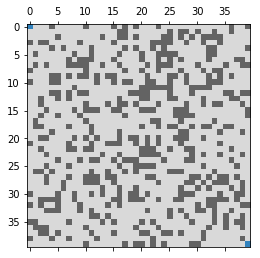

In [556]:
display_labyrinth(grid, START_CELL, END_CELL)
print("Width : ", WIDTH, " Height : ", HEIGHT)
print("Chromosone Length : ", CHROMOSOME_LENGTH)

# Data Structure

In [557]:
DIRECTIONS = {
    0: (-1, 0), # TOP
    1: (0, 1),  # RIGHT
    2: (1, 0),  # BOTTOM
    3: (0, -1), # LEFT
}
DIRECTIONS_LENGTH = len(DIRECTIONS)

## Generic tools

In [558]:
def check_duplication_point(location, direction, previous_locations):
    location_new = tuple(np.add(location, DIRECTIONS[direction]))
    return grid[location_new] != 1.0 and location_new not in previous_locations

In [559]:
def available_direction(location, previous_locations, start_location, targeted_location):
    directions = []
    
    if location[0] > 0:
        if check_duplication_point(location, 0, previous_locations):
            directions.append(0)
    if location[0] < HEIGHT-1:
        if check_duplication_point(location, 2, previous_locations):
            directions.append(2)
            directions.append(2)
            directions.append(2)
    if location[1] > 0:
        if check_duplication_point(location, 3, previous_locations):
            directions.append(3)
    if location[1] < WIDTH-1:
        if check_duplication_point(location, 1, previous_locations):
            directions.append(1)
            directions.append(1)
            directions.append(1)
    
    return directions

In [560]:
def available_direction_simple(location):
    directions = []
    
    if location[0] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[0]))
        if grid[location_new] != 1.0:
            directions.append(0)
    if location[0] < HEIGHT-1:
        location_new = tuple(np.add(location, DIRECTIONS[2]))
        if grid[location_new] != 1.0:
            directions.append(2)
    if location[1] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[3]))
        if grid[location_new] != 1.0:
            directions.append(3)
    if location[1] < WIDTH-1:
        location_new = tuple(np.add(location, DIRECTIONS[1]))
        if grid[location_new] != 1.0:
            directions.append(1)
    
    return directions

In [561]:
def validate_individual(individual, start_location, targeted_location):
    previous_locations = set([start_location])
    location = start_location
    direction = None
    end = False
    
    for index, direction in enumerate(individual):
        if end:
            continue
        
        # Validate every direction in an individual
        directions = available_direction(location, previous_locations, start_location, targeted_location)
        if len(directions) == 0:
            direction = random.choice(available_direction_simple(location))
        elif direction not in directions:
            # Find another valid direction
            direction = random.choice(directions)
        
        # Compute new location
        location = tuple(np.add(location, DIRECTIONS[direction]))
        
        individual[index] = direction
        previous_locations.add(location)
        
        if location == targeted_location:
            end = True
    
    return individual#, previous_locations

In [562]:
def compute_direction_to_path(individual, start_location):
    locations = [start_location]
    location = start_location
    for direction in individual:
        location = tuple(np.add(location, DIRECTIONS[direction]))
        locations.append(location)
    return locations

In [573]:
def optimise_path(individual, locations, targeted_location):
    previous_location = locations[0]
    location_visited = {}
    locations_known = {}
    
    i = 0
    while i < len(individual):
        if locations[i] in locations[i+1:]:
            index = locations[i+1:].index(locations[i])+i+1
            individual[:] = individual[:i]+individual[index:]
            locations[:] = locations[:i]+locations[index:]
            #print(locations)
            print("optimised")
        i += 1
        
    return individual

#optimise_path([1,2,3,4,5,6,7,8,9,10],[(0,0),(0,1),(0,2),(0,3),(0,2),(1,2),(1,1),(2,1),(3,1),(3,2)], (3,2))

In [574]:
def evaluate(individual, start_location, targeted_location):
    individual = validate_individual(individual, start_location, targeted_location)
    
    locations = compute_direction_to_path(individual, start_location)
    
    if targeted_location in locations:
        individual[:] = individual[:locations.index(targeted_location)]
        locations[:] = locations[:locations.index(targeted_location)+1]
        
        individual[:] = optimise_path(individual, locations, targeted_location)
        
        # Score equals to the length of the path
        score = locations.index(targeted_location)
    else:
        # Score equals to length of the individual + the remaining distance
        distance = tuple(np.subtract(locations[-1], targeted_location))
        manhattan_distance = abs(distance[0])+abs(distance[1])
        score = len(individual) + manhattan_distance
        score *= score
    return score,

In [575]:
def resize_individual(length):
    def resize(individual):
        individual[:] = individual[:length]
        return individual
    return resize

## Deap Framework

In [576]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import operator
from enum import Enum
from collections import namedtuple
import random
import time

In [577]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [578]:
#toolbox.register("individual", init_individual, CHROMOSOME_LENGTH_START)
toolbox.register("direction", random.randint, 0, DIRECTIONS_LENGTH-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.direction, CHROMOSOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#toolbox.register("mate", tools.cxOnePoint)
toolbox.register("validate", validate_individual, start_location=START_CELL, targeted_location=END_CELL)
toolbox.register("resize", resize_individual)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.5)
toolbox.register("select", tools.selRoulette)
toolbox.register("evaluate", evaluate, start_location=START_CELL, targeted_location=END_CELL)

In [579]:
#from scoop import futures
from multiprocessing import Pool
pool = Pool(4)
#toolbox.register("map", pool.map)

In [580]:
def solve_labyrinth(grid, start_cell, end_cell, max_time_s):
    population = toolbox.population(100)
    cxpb = 0.7
    mutpb = 0.1
    halloffame = tools.HallOfFame(1)

    start_time = inter_time = time.time()
    
    # Evaluate the individuals with an invalid fitness
    #map(toolbox.validate, population)
    fitnesses = map(toolbox.evaluate, population)

    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)
        
    nb_gen = 0
    pop_size = CHROMOSOME_LENGTH
    # Begin the generational process
    while inter_time - start_time < max_time_s:
        nb_gen += 1
        
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        #map(toolbox.validate, population)
        fitnesses = map(toolbox.evaluate, population)
        
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)
        
        locations = compute_direction_to_path(halloffame[0], START_CELL)
        #print(halloffame[0])
        #print(solution)
        if END_CELL in locations:
            print("find solution")
            pass
            #display_labyrinth(grid, START_CELL, END_CELL, solution)
            #print("solution found, size:", individual)
            #solution = solution[:solution.index(END_CELL)+1]
            #pop_size = solution.index(END_CELL)+1
            
            #print("new size after resize: ", new_length)
            #population[:] = map(toolbox.resize(pop_size), offspring)
            #print("pop size : ",pop_size)
        
        else:
            # Replace the current population by the offspring
            population[:] = offspring
        
        inter_time = time.time()
        
    res = population

    solution = compute_direction_to_path(halloffame[0], START_CELL)
    print("solution : ", halloffame[0])
    print("score : ", halloffame[0].fitness)
    if END_CELL in solution:
        solution = solution[:solution.index(END_CELL)]
    
    print("Length : ", len(solution))
    print("nb gen :", nb_gen)
    display_labyrinth(grid, START_CELL, END_CELL, solution)

solution :  [1, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 0, 2, 3, 2, 0, 1, 2, 1, 0, 1, 2, 3, 1, 1, 2, 2, 1, 2, 2, 1, 3, 2, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 3, 2, 2, 3, 2, 1, 1, 2, 2, 3, 3, 1, 3, 3, 0, 1, 1, 3, 1, 3, 2, 1, 3, 2, 1, 2, 2, 2, 0, 2, 3, 3, 3, 3, 3, 2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 3, 1, 1, 0, 1, 2, 3, 1, 0, 3, 0, 3, 2, 3, 3, 3, 1, 0, 0, 3, 0, 2, 3, 2, 2, 2, 1, 2, 0, 3, 1, 3, 1, 0, 1, 2, 2, 3, 2, 2, 3, 1, 2, 0, 1, 1, 0, 1, 3, 0, 2, 1, 2]
score :  (23716.0,)
Length :  151
nb gen : 18


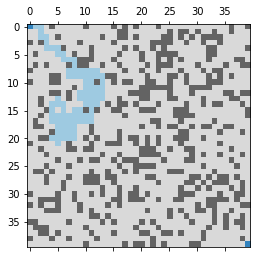

In [480]:
solve_labyrinth(grid, START_CELL, END_CELL, 10)

In [571]:
population = toolbox.population(150)
elites = tools.HallOfFame(1)

optimised
optimised
optimised
optimised
optimised
optimised
Found Score : 116
optimised
optimised
optimised
optimised
Found Score : 134
optimised
optimised
optimised
Found Score : 142
optimised
optimised
optimised
optimised
optimised
Found Score : 118
optimised
optimised
optimised
Found Score : 120
optimised
optimised
optimised
optimised
optimised
optimised
optimised
optimised
optimised
optimised
Found Score : 118
optimised
optimised
optimised
optimised
optimised
optimised
Found Score : 106
optimised
optimised
optimised
optimised
optimised
optimised
optimised
Found Score : 120
optimised
optimised
Found Score : 122
optimised
optimised
optimised
optimised
optimised
optimised
optimised
Found Score : 126
solution :  [2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 2

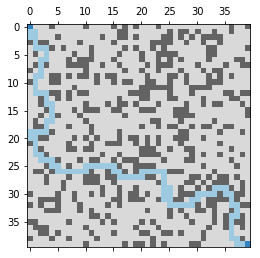

In [572]:
res = algorithms.eaSimple(population, toolbox, 0.7, 0.1, 40, halloffame=elites, verbose=False)
solution = compute_direction_to_path(elites[0], START_CELL)
print("solution : ", elites[0])
print("score : ", elites[0].fitness)
if END_CELL in solution:
    solution = solution[:solution.index(END_CELL)]

print("Length : ", len(solution))
display_labyrinth(grid, START_CELL, END_CELL, solution)